In [1]:
import tifffile as tf
from scipy import ndimage

import numpy as np
import pandas as pd
import numpy.polynomial.polynomial as P

import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
src = '../hpcc/'
dst = '../hpcc/kernel/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

mborder2 = ndimage.generate_binary_structure(2, 1).astype(int)
mborder2[mborder2 == 1] = -1
mborder2[1,1] = -np.sum(mborder2) - 1

In [3]:
idname = 'GB'

rownum = 5
treenum = 3
nutnum = 1

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

GB_R5_T3_001
../hpcc/kernel/GB_R5_T3/


In [4]:
tissuefiles = tsrc + bname + '/' + fname + '_'
meat = tf.imread(tissuefiles + 'meat.tif')

bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
border[border > 0] = 1

Border made of	 855640 pixels

Nut surface area:	 8067.21 mm^2
Approx by a square of size:	 89.82 mm


In [37]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
#nutvoxarea *= resol**2
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

datapoints = np.asarray(np.nonzero(border))
#datapoints = datapoints - np.mean(datapoints, axis=1).reshape(-1,1)
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

kk = 0
phalfx = mcoords[:, (mcoords[0] >  kk)]
nhalfx = mcoords[:, mcoords[0] < -kk]

kk = 1
phalfy = mcoords[:, mcoords[1] >  kk]
nhalfy = mcoords[:, mcoords[1] < -kk]

kk = 1
phalfz = mcoords[:, (mcoords[2] >  kk)]
nhalfz = mcoords[:, mcoords[2] < -kk]

kk = 1
halfc = mcoords[:, np.abs(mcoords[1]) <  kk]

In [68]:
H,x,y = np.histogram2d(phalfx[1], phalfx[2], 100, density=False)
H[H > 0] = 1

bimg = H.copy().astype(int)
bimg[bimg > 0]  = 1
border2 = ndimage.convolve(bimg, mborder2, mode='constant', cval=0)
border2[border2 < 0] = 0
border2[border2 > 0] = 1

c = np.asarray(np.nonzero(border2))
contour = np.vstack((y[c[1]], x[c[0]]))
print(contour.shape)
arg = np.argsort(np.sqrt(np.sum(contour**2, axis=0)))[0]

(2, 510)


In [39]:
thetax = np.angle(contour[0,foo] + contour[1,foo]*1j) - np.pi*.5
rotx = np.array([[np.cos(thetax), -np.sin(thetax)],
                 [np.sin(thetax),  np.cos(thetax)]])
rcontour = rotx.T @ contour

rotx3d = np.array([[1,0,0], 
                 [0, np.cos(thetax), -np.sin(thetax)],
                 [0, np.sin(thetax),  np.cos(thetax)]])

rcoords = rotx3d@mcoords

kk = 0
rhalfx = rcoords[:, rcoords[0] >  kk]

kk = 1
rphalfy = rcoords[:, rcoords[1] >  kk]
rnhalfy = rcoords[:, rcoords[1] < -kk]

kk = 1
rphalfz = rcoords[:, rcoords[2] >  kk]
rnhalfz = rcoords[:, rcoords[2] < -kk]

kk = 1
rhalfc = rcoords[:, np.abs(rcoords[1]) <  kk]

In [98]:
if np.abs(np.sin(thetax)) > 0.05:
    filename = wdst + fname + '_kernel_rotation.csv'
    print(filename)
    np.savetxt(filename, rotx3d, delimiter=',')

In [102]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)

c,b,a = np.sort(kmaxes - kminis)*.5

krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(a*b))
janke = c/np.sqrt((a**2 + b**2 + c**2)/3)

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([krumbein, corey, sneed, janke, c/a],3), sep='\t')

15.75	14.65	14.28
[0.945 0.94  0.96  0.958 0.907]


In [47]:
kk = 1
mask = (np.abs(mcoords[1]) <= kk) & (np.abs(mcoords[2]) <= kk)
spine = mcoords[:, mask]
outer = mcoords[:, ~mask]

# Bottom clamp

In [48]:
leg0y = np.min(mcoords[0,(mcoords[1] > kk) & (mcoords[2] > kk)])
leg0x, leg0y, leg0z = mcoords[:,mcoords[0] == leg0y].squeeze()

leg1y = np.min(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] > kk)])
leg1x, leg1y, leg1z = mcoords[:,mcoords[0] == leg1y].squeeze()

leg2y = np.min(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] < -kk)])
leg2x, leg2y, leg2z = mcoords[:,mcoords[0] == leg2y].squeeze()

leg3y = np.min(mcoords[0,(mcoords[1] > kk) & (mcoords[2] < -kk)])
leg3x, leg3y, leg3z = mcoords[:,mcoords[0] == leg3y].squeeze()

toex = np.asarray([leg0x, leg1x, leg2x, leg3x])
toey = np.asarray([leg0y, leg1y, leg2y, leg3y])
toez = np.asarray([leg0z, leg1z, leg2z, leg3z])
print('X:\t', toex, '\nY:\t', toey, '\nZ:\t', toez, sep='')

X:	[-15.5374466  -14.72057228 -13.75189266 -14.35272419]
Y:	[ 2.01362332 -6.84899896 -6.93542482  3.65509541]
Z:	[ 1.35048148  1.06032234 -1.01803536 -4.29407149]


In [49]:
arm0y = np.max(mcoords[0,(mcoords[1] > kk) & (mcoords[2] > kk)])
arm0x, arm0y, arm0z = mcoords[:,mcoords[0] == arm0y].squeeze()

arm1y = np.max(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] > kk)])
arm1x, arm1y, arm1z = mcoords[:,mcoords[0] == arm1y].squeeze()

arm2y = np.max(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] < -kk)])
arm2x, arm2y, arm2z = mcoords[:,mcoords[0] == arm2y].squeeze()

arm3y = np.max(mcoords[0,(mcoords[1] > kk) & (mcoords[2] < -kk)])
arm3x, arm3y, arm3z = mcoords[:,mcoords[0] == arm3y].squeeze()

armx = np.asarray([arm0x, arm1x, arm2x, arm3x])
army = np.asarray([arm0y, arm1y, arm2y, arm3y])
armz = np.asarray([arm0z, arm1z, arm2z, arm3z])
print('X:\t', armx, '\nY:\t', army, '\nZ:\t', armz, sep='')

X:	[15.9490777  15.46933839 15.86522626 15.96135107]
Y:	[ 6.7261891  -4.30788832 -4.89525593  5.81652285]
Z:	[ 2.85489776  4.52593616 -1.93132373 -3.69291572]


In [50]:
head = np.max(mcoords[0,(np.abs(mcoords[1]) < kk) & (np.abs(mcoords[2]) < kk)])
head = mcoords[:,mcoords[0] == head].squeeze()
print(head)

[13.81224777  0.70021549 -0.17165069]


In [51]:
print(leg0y - leg1y)
print(leg3y - leg2y)

print(arm0y - arm1y)
print(arm3y - arm2y)

foo = np.argmax(np.abs(head[0] - armx))
print(head[0] - armx[foo])

8.862622279009003
10.59052022717498
11.034077425906677
10.711778781877719
-2.1491032947252613


13.785758435961892	0.7006723175135754	13.085086118448316


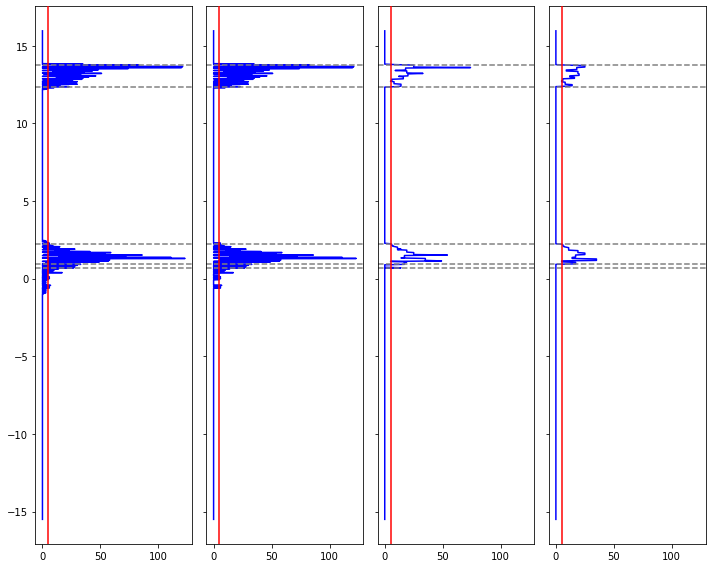

In [57]:
# central bit

kk = 1
hist, bins = np.histogram(spine[0], bins=np.linspace(kminis[0], kmaxes[0], 1000), density = False)
hist0 = hist.copy()
thr = np.quantile(hist0[hist0 > 0], 0.25)
hist[hist < thr] = 0
fhist = ndimage.median_filter(hist, size=5, mode='constant', cval=0)
mhistc = ndimage.minimum_filter1d(fhist, size=3, mode='constant', cval=0)
zeros = bins[1:][(mhistc == 0) & (fhist > 0)]
zeros = zeros[zeros > -3]
htop = np.max(zeros)
hbot = np.min(zeros)
hlength = htop - hbot
print(htop, hbot, hlength, sep='\t')

fig, ax = plt.subplots(1,4,figsize=(10,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel() ; i = 0
ax[i].plot(hist0, bins[1:],c='b'); i += 1
ax[i].plot(hist, bins[1:],c='b'); i += 1
ax[i].plot(fhist, bins[1:],c='b'); i += 1
ax[i].plot(mhistc, bins[1:],c='b')

for i in range(len(ax)):
    ax[i].axvline(thr, c='r', zorder=9)
    for z in zeros:
        ax[i].axhline(z, c='gray', ls='--')

fig.tight_layout();

In [81]:
# lower arch height
atop = hbot
abot = np.median(legx)
alength = atop - abot
print(atop, abot, alength, sep='\t')

if False:
    kk = 1
    hist, bins = np.histogram(mcoords[0,(np.abs(mcoords[1]) < kk)],# & (np.abs(mcoords[2]) < kk)], 
                              bins=np.linspace(kminis[0], kmaxes[0], 1000),
                              density = False)
    hist0 = hist.copy()
    thr = np.quantile(hist0[hist0 > 0], 0.25)
    #thr = 50
    hist[hist < thr] = 0
    fhist = ndimage.median_filter(hist, size=5, mode='constant', cval=0)
    mhista = ndimage.minimum_filter1d(fhist, size=3, mode='constant', cval=0)
    zeros = bins[1:][(mhista == 0) & (fhist > 0)]
    zeros = zeros[zeros < 3]
    atop = np.max(zeros)
    abot = np.min(toex)
    alength = atop - abot
    print(atop, abot, alength, sep='\t')

    fig, ax = plt.subplots(1,4,figsize=(10,8), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel() ; i = 0
    ax[i].plot(hist0, bins[1:],c='b'); i += 1
    ax[i].plot(hist, bins[1:],c='b'); i += 1
    ax[i].plot(fhist, bins[1:],c='b'); i += 1
    ax[i].plot(mhista, bins[1:],c='b')

    for i in range(len(ax)):
        ax[i].axvline(thr, c='r', zorder=9)
        for z in zeros:
            ax[i].axhline(z, c='gray', ls='--')
    fig.tight_layout();

0.7006723175135754	-13.392076370560298	14.092748688073874


In [73]:
zeros

array([-13.33032364, -13.172672  , -12.76277774,   2.592492  ,
         2.97085593])

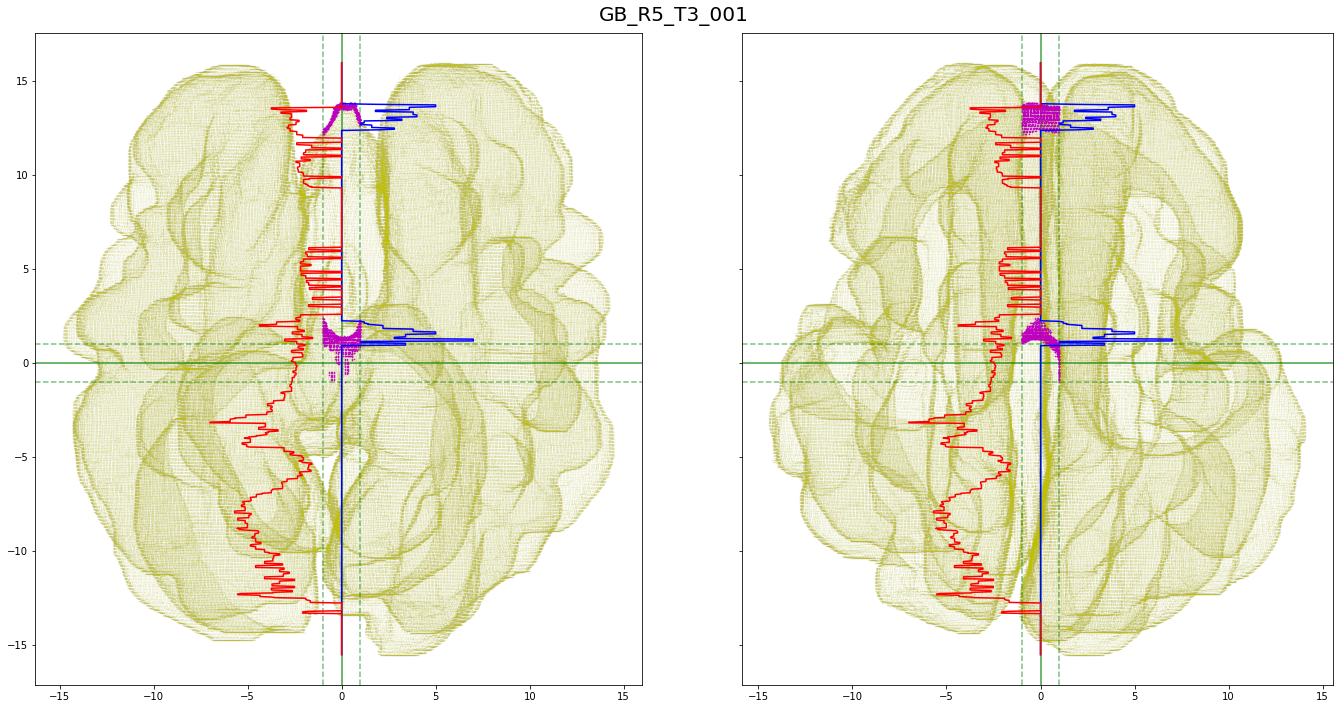

In [60]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(outer[1], outer[0], s=.1, color='y', alpha=0.2, marker='.', zorder=1)
ax[i].scatter(spine[1], spine[0], s=1, color='m', alpha=1, marker='.', zorder=3)
i += 1

ax[i].scatter(outer[2], outer[0], s=.1, color='y', alpha=0.2, marker='.', zorder=1)
ax[i].scatter(spine[2], spine[0], s=1, color='m', alpha=1, marker='.', zorder=3)
i += 1

for i in range(len(ax)):
    ax[i].plot( 7*mhistc/np.max(mhistc), bins[1:], c='b', zorder=3)
    ax[i].plot(-7*mhista/np.max(mhista), bins[1:], c='r', zorder=3)

    ax[i].set_aspect('equal');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);
    
    ax[i].axvline(-kk, c='g',alpha=0.5, ls='--')
    ax[i].axhline(-kk,c='g',alpha=0.5, ls='--');
    ax[i].axvline( kk, c='g',alpha=0.5, ls='--')
    ax[i].axhline( kk,c='g',alpha=0.5, ls='--');

fig.suptitle(fname, fontsize=20);
fig.tight_layout();

In [77]:
mask = (mcoords[0] < -kk) & (mcoords[1] > kk) & (mcoords[2] > kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - np.abs(foo[1])
leg0x, leg0y, leg0z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] < -kk) & (mcoords[2] > kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - np.abs(foo[1])
leg1x, leg1y, leg1z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] < -kk) & (mcoords[2] < -kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - np.abs(foo[1])
leg2x, leg2y, leg2z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] > kk) & (mcoords[2] < -kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - np.abs(foo[1])
leg3x, leg3y, leg3z = mcoords[:, np.argmax(bar)]

legx = np.asarray([leg0x, leg1x, leg2x, leg3x])
legy = np.asarray([leg0y, leg1y, leg2y, leg3y])
legz = np.asarray([leg0z, leg1z, leg2z, leg3z])
print('X:\t', legx, '\nY:\t', legy, '\nZ:\t', legz, sep='')

X:	[-15.46220948 -14.35793315 -12.42621959 -12.41028999]
Y:	[ 1.93822249 -1.95359693 -2.041375    1.00582842]
Z:	[ 1.36373712  2.07628739 -2.86824707 -4.74763523]


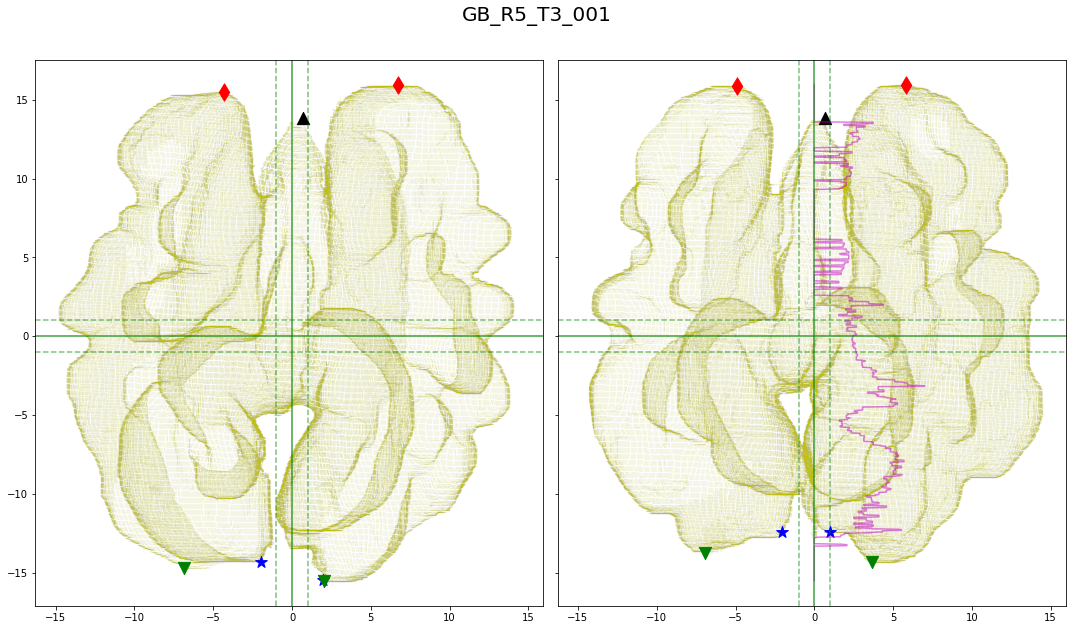

In [78]:
phalf = mcoords[:, mcoords[2] >  kk]
nhalf = mcoords[:, mcoords[2] < -kk]

fig, ax = plt.subplots(1,2,figsize=(15,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].scatter(phalf[1], phalf[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(legy[:2], legx[:2], s=150, color='b', marker='*');
ax[i].scatter(toey[:2], toex[:2], s=150, color='g', marker='v');
ax[i].scatter(army[:2], armx[:2], s=150, color='r', marker='d');
ax[i].scatter(head[1], head[0], s=150, color='k', marker='^');

i += 1
ax[i].scatter(nhalf[1], nhalf[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(legy[2:], legx[2:], s=150, color='b', marker='*');
ax[i].scatter(toey[2:], toex[2:], s=150, color='g', marker='v');
ax[i].scatter(army[2:], armx[2:], s=150, color='r', marker='d');
ax[i].scatter(head[1], head[0], s=150, color='k', marker='^');
ax[i].plot(7*mhista/np.max(mhista), bins[1:], c='m', alpha=0.5)

for i in range(len(ax)):
    ax[i].set_aspect('equal');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);
    
    ax[i].axvline(-kk, c='g',alpha=0.5, ls='--')
    ax[i].axhline(-kk,c='g',alpha=0.5, ls='--');
    ax[i].axvline( kk, c='g',alpha=0.5, ls='--')
    ax[i].axhline( kk,c='g',alpha=0.5, ls='--');

fig.suptitle(fname, fontsize=20);
fig.tight_layout();

../hpcc/kernel/GB_R5_T3/GB_R5_T3_001_kernel.jpg


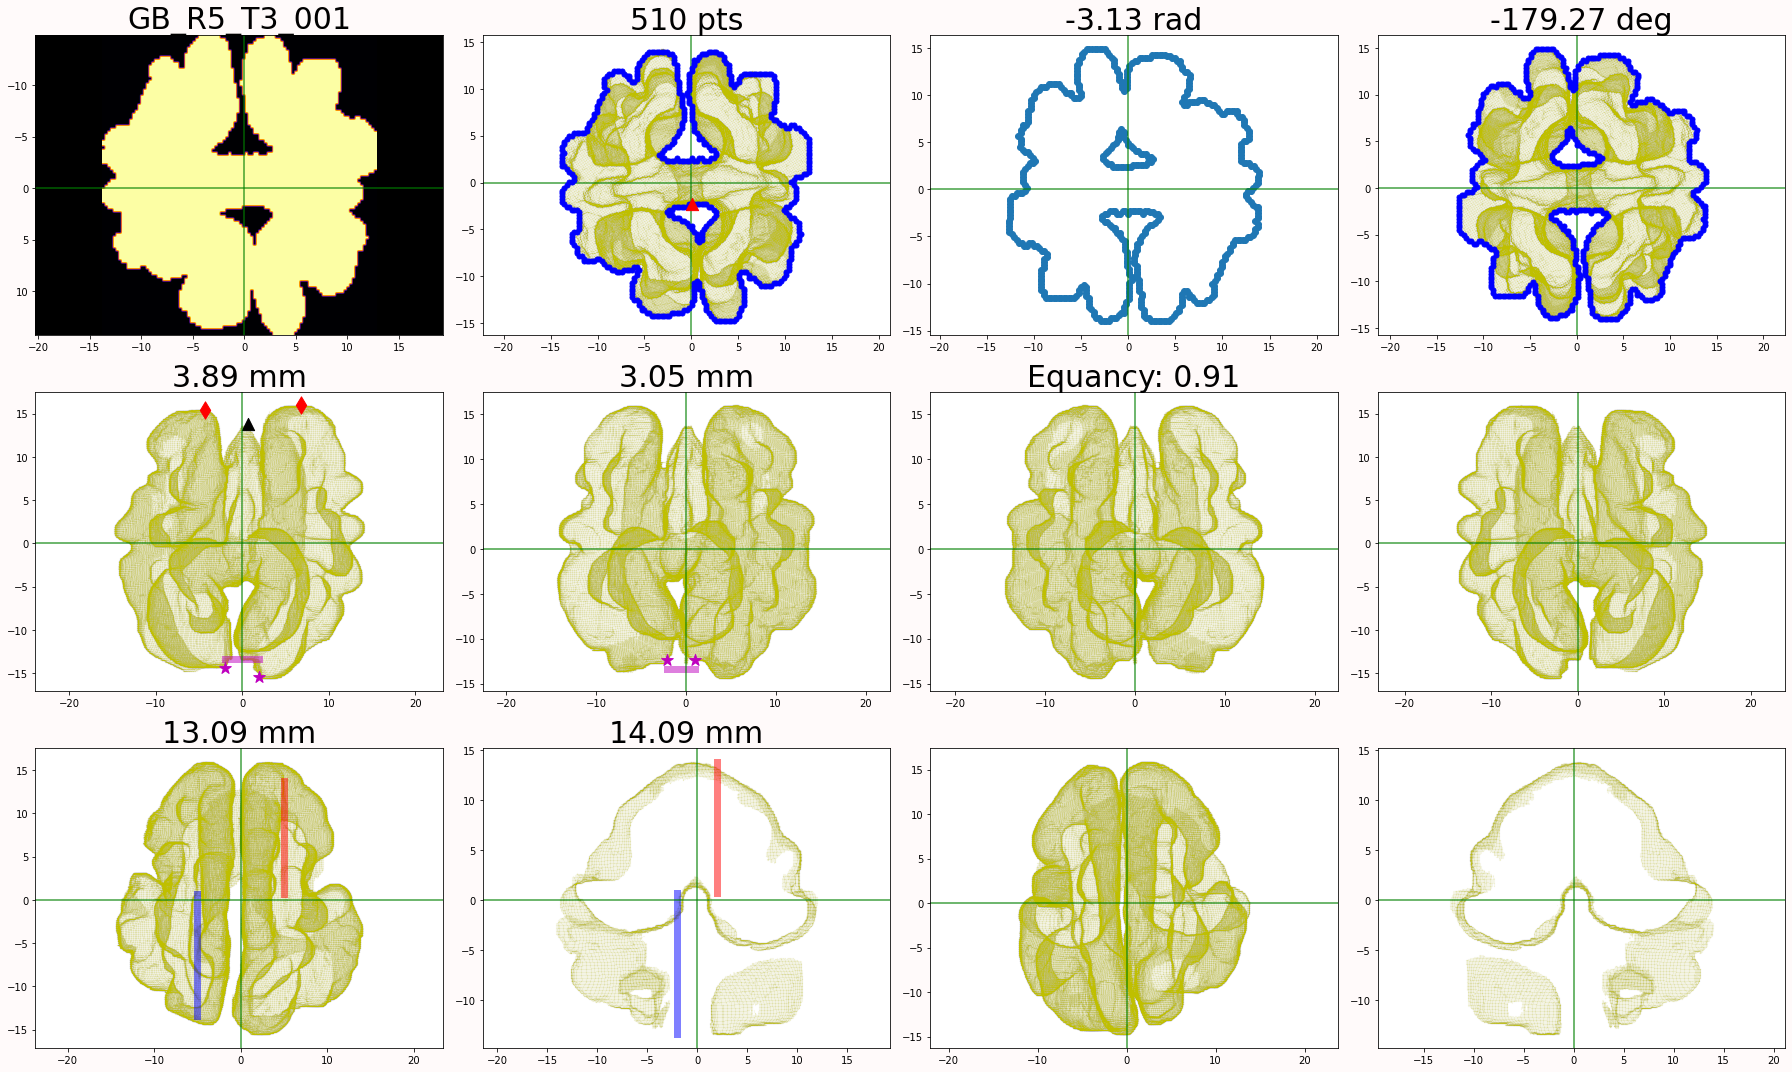

In [108]:
fs = 30

fig, ax = plt.subplots(3,4,figsize=(25,15), sharex=False, sharey=False, facecolor='snow')
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(H, origin='lower', cmap='inferno', extent=[y[0],y[-1],x[-1],x[0]]) 
ax[i].set_facecolor('k')
ax[i].set_title(fname, fontsize=fs)
i += 1
ax[i].scatter(phalfx[2], phalfx[1], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(contour[0], contour[1], s=25, zorder=3, c='b')
ax[i].scatter(contour[0,arg], contour[1,arg], marker='^', s=150, c='r', zorder=10)
ax[i].set_title('{} pts'.format(contour.shape[1]), fontsize=fs)
i += 1
ax[i].scatter(rcontour[0], rcontour[1])
ax[i].set_title('{:.2f} rad'.format(thetax), fontsize=fs)
i += 1
ax[i].scatter(rhalfx[2], rhalfx[1], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(rcontour[0], rcontour[1], s=25, zorder=3, c='b')
ax[i].set_title('{:.2f} deg'.format(np.rad2deg(thetax)), fontsize=fs)
i += 1

######

ax[i].scatter(phalfz[1], phalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(legy[:2], legx[:2], s=150, color='m', marker='*');
ax[i].scatter(army[:2], armx[:2], s=150, color='r', marker='d');
ax[i].scatter(head[1], head[0], s=150, color='k', marker='^');

ax[i].plot(legy[:2], np.repeat(abot,2), lw=7, c='m', alpha=0.5);
ax[i].set_title('{:.2f} mm'.format(legy[0]-legy[1]), fontsize=fs)
i += 1
ax[i].scatter(nhalfz[1], nhalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(legy[2:], legx[2:], s=150, color='m', marker='*');
ax[i].scatter(army[2:], armx[2:], s=150, color='r', marker='d');
ax[i].scatter(head[1], head[0], s=150, color='k', marker='^');
ax[i].plot(legy[2:], np.repeat(abot,2), lw=7, c='m', alpha=0.5);
ax[i].set_title('{:.2f} mm'.format(legy[3]-legy[2]), fontsize=fs)
i += 1
ax[i].scatter(rphalfz[1], rphalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].set_title('Equancy: {:.2f}'.format(c/a), fontsize=fs)
i+=1
ax[i].scatter(rnhalfz[1], rnhalfz[0], s=.1, color='y', alpha=.2, marker='.')
i += 1

######

ax[i].scatter(phalfy[2], phalfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([5,5], [htop, hbot], lw=7, c='r', alpha=.5)
ax[i].plot([-5,-5], [atop, abot], lw=7, c='b', alpha=0.5)
ax[i].set_title('{:.2f} mm'.format(hlength), fontsize=fs)
i += 1
ax[i].scatter(halfc[2], halfc[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([2,2], [htop, hbot], lw=7, c='r', alpha=.5)
ax[i].plot([-2,-2], [atop, abot], lw=7, c='b', alpha=0.5)
ax[i].set_title('{:.2f} mm'.format(alength), fontsize=fs)
i += 1
ax[i].scatter(rphalfy[2], rphalfy[0], s=.1, color='y', alpha=.2, marker='.')
i+=1
ax[i].scatter(rhalfc[2], rhalfc[0], s=.1, color='y', alpha=.2, marker='.')
i += 1

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);
fig.tight_layout();

filename = wdst + fname + '_kernel.jpg'
print(filename)
#plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})